In [1]:
from pathlib import Path
import numpy as np
import jax.numpy as jnp
import pandas as pd
import jax
import jraph
import matplotlib.pyplot as plt

In [2]:
data_dir = Path('/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-data/val_split/')

# you can find a train/test/val split of the data in the data directory

In [3]:
halos = jnp.load(data_dir / 'train_halos.npy')

I0000 00:00:1697236471.891488  256598 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [4]:
halos.shape
# There are 1600 independent simulations in the training set, with 5000 objects each, and 7 properties

(1600, 5000, 7)

In [5]:
# First three properties are positions
print(halos[:,:,:3].min(), halos[:,:,:3].max())
# You can see that the simulation is ran with periodic boundary conditions, and the boxsize is 1000.


0.0 999.99994


In [6]:
# Next 3 properties are velocities, and the last one is the mass of each object
print(halos[:,:,3:6].min(), halos[:,:,:3:6].max())


-3208.7217 999.9999


In [7]:
halos[0,:,-1].shape

(5000,)

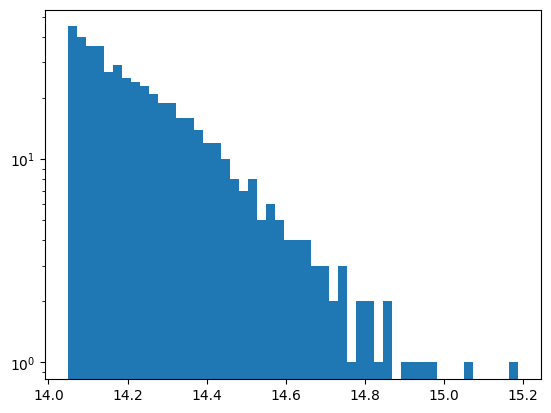

In [8]:
# this is the distribution of masses for one simulation
# Masses are really large, so normally we log them
_ = plt.hist(np.array(jnp.log10(halos[0,::10,-1])), bins=50, log=True,)


## Let's look at the cosmological parameters for each simulation

In [9]:
cosmology = pd.read_csv(data_dir / f'train_cosmology.csv')
print(len(cosmology))

1600


In [10]:
cosmology.head(3)

,Omega_m,Omega_b,h,n_s,sigma_8
0,0.1755,0.06681,0.7737,0.8849,0.6641
1,0.2139,0.05557,0.8599,0.9785,0.8619
2,0.1867,0.04503,0.6189,0.8307,0.7187


In [11]:
omega_m = jnp.array(cosmology['Omega_m'].values)[:,None]

In [12]:
omega_m

Array([[0.1755],
       [0.2139],
       [0.1867],
       ...,
       [0.3431],
       [0.4539],
       [0.4191]], dtype=float32)

The one the pointcloud will be more sensitive to, is Omega_m so we will start with that one

## Let's build the simplest GNN to predict Omega_m from halo positions

In [13]:

# First let's work on a baseline. Cosmologists have used what we call the two point correlation function to extract information on parameters like Omega_m

In [14]:
from pycorr import TwoPointCorrelationFunction # Can install it here https://github.com/cosmodesi/pycorr

r_bins = np.linspace(0.5, 150.0, 25)
r_c = 0.5*(r_bins[1:] + r_bins[:-1])
mu_bins = np.linspace(-1, 1, 201)
box_size = 1000.

tpcfs = []
for halo in halos:
    tpcfs.append(
        TwoPointCorrelationFunction(
                "smu",
                edges=(np.array(r_bins), np.array(mu_bins)),
                data_positions1=np.array(halo[:,:3]).T,
                engine="corrfunc",
                n_threads=2,
                boxsize=box_size,
                los="z",
            )(ells=[0])[0]
    )
tpcfs = jnp.stack(tpcfs)



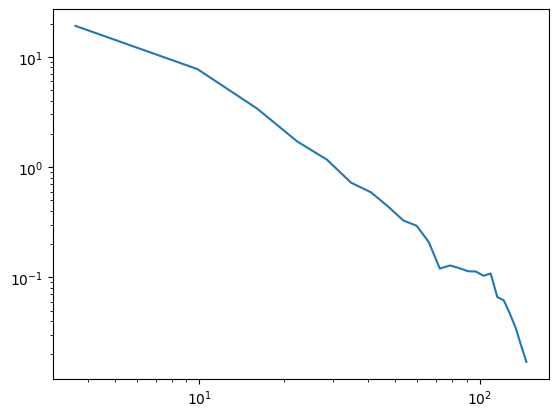

In [15]:
# This is how one of the tpcfs looks like
plt.loglog(
    r_c, tpcfs[2]
)
# It tells you how likely it is to find a pair of galaxies at a given pair separation r

In [16]:
# let's build a simple flax model that can process these tpcfs
import flax.linen as nn
from typing import Sequence, Callable


class MLP(nn.Module):
    """A simple MLP."""

    feature_sizes: Sequence[int]
    activation: Callable[[np.ndarray], np.ndarray] = nn.gelu

    @nn.compact
    def __call__(self, x):
        for features in self.feature_sizes[:-1]:
            x = nn.Dense(features)(x)
            x = self.activation(x)

        # No activation on final layer
        x = nn.Dense(self.feature_sizes[-1])(x)
        return x


mlp = MLP(feature_sizes=[128,128,128, 1])
# and let's intialize some parameters for it by using an example input
key = jax.random.PRNGKey(0)
params = mlp.init(key, tpcfs[:3])


def loss_fn(params, x_batch, cosmo_batch,):
    pred_cosmo = mlp.apply(params, x_batch)
    return jnp.mean(pred_cosmo - cosmo_batch)**2

In [17]:
import optax
from tqdm import trange



In [18]:

opt = optax.adamw(learning_rate=1e-2, weight_decay=1e-4)
opt_state = opt.init(params)

n_steps = 500 
n_batch = 32

with trange(n_steps) as steps:
    for step in steps:
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, tpcfs.shape[0], shape=(n_batch,))
        
        tpcf_batch, cosmo_batch = tpcfs[idx], omega_m[idx]
        loss, grads = jax.value_and_grad(loss_fn)(params, tpcf_batch, cosmo_batch)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(loss=loss)

100%|██████████| 500/500 [00:42<00:00, 11.80it/s, loss=2.5469628e-05] 


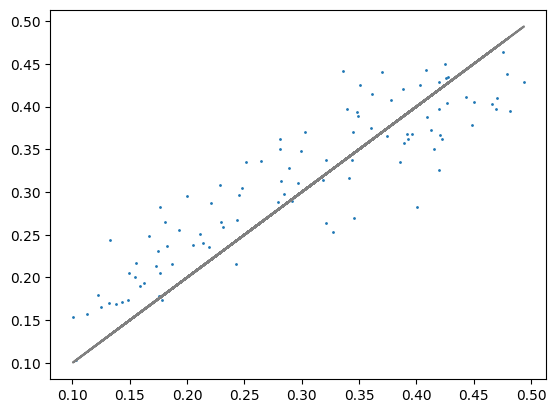

In [19]:
# let's see whether the model has learned to do the right thing to first order

omega_m_pred = mlp.apply(params, tpcfs[:100])

plt.scatter(omega_m[:100], omega_m_pred[:,0], s=1)
plt.plot(omega_m[:100], omega_m[:100], color='gray')

## Now let's see what a silly graph can do

In [20]:
from functools import partial

EPS = 1e-5

def apply_pbc(dr: np.array, cell: np.array) -> np.array:
    """Apply periodic boundary conditions to a displacement vector, dr, given a cell.

    Args:
        dr (np.array): An array of shape (N,3) containing the displacement vector
        cell_matrix (np.array): A 3x3 matrix describing the box dimensions and orientation.

    Returns:
        np.array: displacement vector with periodic boundary conditions applied
    """
    return dr - jnp.round(dr.dot(jnp.linalg.inv(cell))).dot(cell)


@partial(jax.jit, static_argnums=(1, 3))
def nearest_neighbors(
    x: np.array,
    k: int,
    cell: np.array = None,
    pbc: bool = False,
):
    """Returns the nearest neighbors of each node in x.

    Args:
        x (np.array): positions of nodes
        k (int): number of nearest neighbors to find
        mask (np.array, optional): node mask. Defaults to None.

    Returns:
        sources, targets: pairs of neighbors
    """
    n_nodes = x.shape[0]
    # Compute the vector difference between positions
    dr = (x[:, None, :] - x[None, :, :]) + EPS
    if pbc:
        dr = apply_pbc(
            dr=dr,
            cell=cell,
        )

    # Calculate the distance matrix
    distance_matrix = np.sum(dr**2, axis=-1)

    # Get indices of nearest neighbors
    indices = np.argsort(distance_matrix, axis=-1)[:, :k]

    # Create sources and targets arrays
    sources = np.repeat(np.arange(n_nodes), k)
    targets = indices.ravel()

    # return sources, targets, distance_matrix[sources, targets]
    return sources, targets, dr[sources, targets]

In [45]:

cell = jnp.array([[1.,0.,0.,],[0.,1.,0.], [0.,0.,1.]])
def build_graph(halo_pos, k, use_pbc=True, use_edges=True,):
    n_batch = len(halo_pos)
    sources, targets, distances = jax.vmap(partial(nearest_neighbors, pbc=use_pbc), in_axes=(0, None, None))(halo_pos, k, cell)
    return jraph.GraphsTuple(
            n_node=jnp.array([[halo_pos.shape[1]]]*n_batch),
            n_edge=jnp.array(n_batch * [[k]]),
            nodes=halo_pos, # node features
            edges=distances if use_edges else None, # edge features
            globals=jnp.array([[0.]*n_batch]).T, # global features
            senders=sources, 
            receivers=targets,
        )

In [46]:
# let's build a graph based on halo positions and k nearest neighbors
halo_pos = halos[...,:3]/1000. # let's divide by the boxsize so they are all between 0 and 1
k = 5


In [47]:
# now we can build a graph for a batch

graph = build_graph(halo_pos[:5], k=5)

In [48]:
from jraph._src import utils
import jax.tree_util as tree

In [58]:
# let's build a dumb message passing GNN with jraph


def get_node_mlp_updates(mlp_feature_sizes: int, name: str = None):
    """Get a node MLP update  function

    Args:
        mlp_feature_sizes (int): number of features in the MLP
        name (str, optional): name of the update function. Defaults to None.

    Returns:
        Callable: update function
    """

    def update_fn(
        nodes: jnp.ndarray,
        sent_attributes: jnp.ndarray,
        received_attributes: jnp.ndarray,
        globals: jnp.ndarray,
    ) -> jnp.ndarray:
        """update node features

        Args:
            nodes (jnp.ndarray): node features
            sent_attributes (jnp.ndarray): attributes sent to neighbors
            received_attributes (jnp.ndarray): attributes received from neighbors
            globals (jnp.ndarray): global features

        Returns:
            jnp.ndarray: updated node features
        """
        if received_attributes is not None:
            inputs = jnp.concatenate([nodes, received_attributes, globals], axis=1)
        else:  # If lone node
            inputs = jnp.concatenate([nodes, globals], axis=1)
        return MLP(mlp_feature_sizes, name=name)(inputs)

    return update_fn


def get_edge_mlp_updates(mlp_feature_sizes: int, name: str = None):
    """Get an edge MLP update function

    Args:
        mlp_feature_sizes (int): number of features in the MLP
        name (str, optional): name of the update function. Defaults to None.

    Returns:
        Callable: update function
    """

    def update_fn(
        edges: jnp.ndarray,
        senders: jnp.ndarray,
        receivers: jnp.ndarray,
        globals: jnp.ndarray,
    ) -> jnp.ndarray:
        """update edge features

        Args:
            edges (jnp.ndarray): edge attributes
            senders (jnp.ndarray): senders node attributes
            receivers (jnp.ndarray): receivers node attributes
            globals (jnp.ndarray): global features

        Returns:
            jnp.ndarray: updated edge features
        """
        # If there are no edges in the initial layer
        if edges is not None:
            inputs = jnp.concatenate([edges, senders, receivers, globals], axis=1)
        else:
            inputs = jnp.concatenate([senders, receivers, globals], axis=1)
        return MLP(mlp_feature_sizes, name=name)(inputs)

    return update_fn

class Identity(nn.Module):
    """Module that applies the identity function, ignoring any additional args."""

    @nn.compact
    def __call__(self, x, **args):
        return x

def make_global_mlp(features):
  @jraph.concatenated_args
  def update_fn(inputs):
    return MLP(features)(inputs)
  return update_fn

def pool_globals(graph, global_mlp, aggregate_nodes_for_globals_fn=utils.segment_mean, aggregate_edges_for_globals_fn=utils.segment_mean, ):
    nodes, edges, receivers, senders, globals_, n_node, n_edge = graph
    n_graph = n_node.shape[0]
    graph_idx = jnp.arange(n_graph)
    sum_n_node = tree.tree_leaves(nodes)[0].shape[0]
    sum_n_edge = senders.shape[0]
    # To aggregate nodes and edges from each graph to global features,
    # we first construct tensors that map the node to the corresponding graph.
    # For example, if you have `n_node=[1,2]`, we construct the tensor
    # [0, 1, 1]. We then do the same for edges.
    node_gr_idx = jnp.repeat(
        graph_idx, n_node, axis=0, total_repeat_length=sum_n_node)
    edge_gr_idx = jnp.repeat(
        graph_idx, n_edge, axis=0, total_repeat_length=sum_n_edge)
    # We use the aggregation function to pool the nodes/edges per graph.
    node_attributes = tree.tree_map(
        lambda n: aggregate_nodes_for_globals_fn(n, node_gr_idx, n_graph),
        nodes)
    edge_attribtutes = tree.tree_map(
        lambda e: aggregate_edges_for_globals_fn(e, edge_gr_idx, n_graph),
        edges)
    # These pooled nodes are the inputs to the global update fn.
    jax.debug.print('node shape = {x}',x=node_attributes.shape)
    jax.debug.print('edge shape = {x}',x=edge_attribtutes.shape)
    globals = global_mlp(node_attributes, edge_attribtutes,)
    jax.debug.print('globals shape = {x}',x=globals.shape)
    return globals

class GNN(nn.Module):
    """A simple graph convolutional network"""

    latent_size: int
    hidden_size: int
    num_mlp_layers: int
    message_passing_steps: int
    skip_connections: bool = False 
    norm: str = "layer"
    attention: bool = False
    in_features: int = 3
    shared_weights: bool = False  # GNN shares weights across message passing steps

    @nn.compact
    def __call__(self, graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        """Do message passing on graph

        Args:
            graphs (jraph.GraphsTuple): graph object

        Returns:
            jraph.GraphsTuple: updated graph object
        """
        if graph.globals is not None:
            graph= graph._replace(globals=graph.globals.reshape(1, -1))

        mlp_feature_sizes = [self.hidden_size] * self.num_mlp_layers + [self.latent_size]
        if graph.edges is None:
            embedder = jraph.GraphMapFeatures(embed_node_fn=MLP(mlp_feature_sizes))
        else:
            embedder = jraph.GraphMapFeatures(embed_node_fn=MLP(mlp_feature_sizes), embed_edge_fn=MLP(mlp_feature_sizes))
        graph = embedder(graph)

        # Apply GCN once for each message-passing round.
        for step in range(self.message_passing_steps):
            # Initialize update functions with shared weights if specified;
            # otherwise, initialize new weights for each step
            if step == 0 or not self.shared_weights:
                suffix = "shared" if self.shared_weights else step

                update_node_fn = get_node_mlp_updates(mlp_feature_sizes, name=f"update_node_fn_{suffix}")
                update_edge_fn = get_edge_mlp_updates(mlp_feature_sizes, name=f"update_edge_fn_{suffix}")

                # Update nodes and edges; no need to update globals as they only condition
                graph_net = jraph.GraphNetwork(
                    update_node_fn=update_node_fn,
                    update_edge_fn=update_edge_fn,
                )

            # Update graph, optionally with residual connection
            if self.skip_connections:
                new_graph = graph_net(graph)
                graph = graph._replace(
                    nodes=graph.nodes + new_graph.nodes,
                    edges=new_graph.edges if graph.edges is None else graph.edges + new_graph.edges,
                    globals=new_graph.globals if graph.globals is None else graph.globals + new_graph.globals,
                )
            else:
                graph = graph_net(graph)

            # Optional normalization
            if self.norm == "layer":
                norm = nn.LayerNorm()
            else:
                norm = Identity()  # No normalization

            graph = graph._replace(nodes=norm(graph.nodes), edges=norm(graph.edges))

        global_mlp = make_global_mlp(mlp_feature_sizes + [1,],)

        return pool_globals(graph, global_mlp)


In [59]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, x):
        model = jax.vmap(GNN(latent_size=16,hidden_size=64, num_mlp_layers=2, message_passing_steps=2))
        return model(x)



In [60]:

gnn = GraphWrapper()
# and let's intialize some parameters for it by using an example input
key = jax.random.PRNGKey(0)
graph = build_graph(halo_pos[:2], k, use_pbc=True, use_edges=True)

params = gnn.init(key, graph)

node shape = (1, 16)
edge shape = (1, 16)
globals shape = (1, 1)


In [61]:


@jax.jit
def loss_fn(params, x_batch, cosmo_batch,):
    pred_cosmo = gnn.apply(params, x_batch)
    return jnp.mean(pred_cosmo - cosmo_batch)**2

In [62]:
opt = optax.adamw(learning_rate=1e-2, weight_decay=1e-4)
opt_state = opt.init(params)

n_steps = 100 
n_batch = 6 

with trange(n_steps) as steps:
    for step in steps:
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, halo_pos.shape[0], shape=(n_batch,))
        
        halo_batch, cosmo_batch = halo_pos[idx], omega_m[idx]

        # build graph
        graph = build_graph(halo_batch, k, use_pbc=True, use_edges=True)
        loss, grads = jax.value_and_grad(loss_fn)(params, graph, cosmo_batch)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(loss=loss)

  0%|          | 0/100 [00:00<?, ?it/s]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


  2%|▏         | 2/100 [00:04<03:13,  1.97s/it, loss=0.13656512]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


  4%|▍         | 4/100 [00:05<01:12,  1.33it/s, loss=0.18998618]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


  6%|▌         | 6/100 [00:05<00:37,  2.49it/s, loss=0.11539368]  

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


  8%|▊         | 8/100 [00:05<00:24,  3.80it/s, loss=0.011959958]  

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 10%|█         | 10/100 [00:05<00:18,  4.97it/s, loss=0.07254731] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 12%|█▏        | 12/100 [00:06<00:15,  5.79it/s, loss=0.011916686] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 14%|█▍        | 14/100 [00:06<00:13,  6.28it/s, loss=0.0060101626] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 16%|█▌        | 16/100 [00:06<00:12,  6.53it/s, loss=0.00014036006]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 18%|█▊        | 18/100 [00:07<00:12,  6.69it/s, loss=0.014508432]  

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 20%|██        | 20/100 [00:07<00:11,  6.79it/s, loss=0.0029674086]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 22%|██▏       | 22/100 [00:07<00:11,  6.84it/s, loss=0.009525914] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 24%|██▍       | 24/100 [00:07<00:11,  6.88it/s, loss=7.110942e-05]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 26%|██▌       | 26/100 [00:08<00:11,  6.71it/s, loss=0.035317995] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 28%|██▊       | 28/100 [00:08<00:10,  6.77it/s, loss=0.009029158]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 30%|███       | 30/100 [00:08<00:10,  6.84it/s, loss=0.010162156]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 32%|███▏      | 32/100 [00:09<00:09,  6.87it/s, loss=0.008631873]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 34%|███▍      | 34/100 [00:09<00:09,  6.85it/s, loss=0.026231207]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 36%|███▌      | 36/100 [00:09<00:09,  6.88it/s, loss=0.01608553]  

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 38%|███▊      | 38/100 [00:10<00:09,  6.64it/s, loss=0.008639513]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 40%|████      | 40/100 [00:10<00:10,  5.62it/s, loss=0.0005704977] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 42%|████▏     | 42/100 [00:10<00:12,  4.63it/s, loss=0.0024562336]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 43%|████▎     | 43/100 [00:11<00:11,  5.08it/s, loss=0.018684775] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 45%|████▌     | 45/100 [00:11<00:09,  5.82it/s, loss=0.0042493334]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 47%|████▋     | 47/100 [00:11<00:08,  6.29it/s, loss=0.0007255255]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 49%|████▉     | 49/100 [00:11<00:07,  6.61it/s, loss=0.0077691544]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 51%|█████     | 51/100 [00:12<00:07,  6.70it/s, loss=0.004146245]  

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 53%|█████▎    | 53/100 [00:12<00:06,  6.77it/s, loss=0.005350844] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 55%|█████▌    | 55/100 [00:12<00:06,  6.82it/s, loss=0.0040425947]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 57%|█████▋    | 57/100 [00:13<00:06,  6.82it/s, loss=0.0011183404]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 59%|█████▉    | 59/100 [00:13<00:05,  6.86it/s, loss=0.0032093595]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 61%|██████    | 61/100 [00:13<00:05,  6.85it/s, loss=0.0011832493]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 63%|██████▎   | 63/100 [00:13<00:05,  6.88it/s, loss=0.0037511624] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 65%|██████▌   | 65/100 [00:14<00:05,  6.83it/s, loss=0.0053990656]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 67%|██████▋   | 67/100 [00:14<00:04,  6.82it/s, loss=0.0034792314]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 69%|██████▉   | 69/100 [00:14<00:04,  6.81it/s, loss=0.0014312732]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 71%|███████   | 71/100 [00:15<00:04,  6.83it/s, loss=0.006677383]  

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 73%|███████▎  | 73/100 [00:15<00:04,  5.76it/s, loss=0.001053965]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 74%|███████▍  | 74/100 [00:15<00:04,  5.57it/s, loss=5.606075e-06]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 76%|███████▌  | 76/100 [00:16<00:03,  6.14it/s, loss=0.000704565] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 78%|███████▊  | 78/100 [00:16<00:03,  6.49it/s, loss=0.010528272] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 80%|████████  | 80/100 [00:16<00:03,  5.43it/s, loss=0.0002691439]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 81%|████████  | 81/100 [00:16<00:03,  5.28it/s, loss=0.00019485623]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 82%|████████▏ | 82/100 [00:17<00:03,  5.60it/s, loss=0.0018370595] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 84%|████████▍ | 84/100 [00:17<00:02,  6.21it/s, loss=0.0040215966]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 86%|████████▌ | 86/100 [00:17<00:02,  6.46it/s, loss=0.0043113786]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 88%|████████▊ | 88/100 [00:17<00:01,  6.60it/s, loss=0.0037317104]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 90%|█████████ | 90/100 [00:18<00:01,  6.76it/s, loss=0.0043353923]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 92%|█████████▏| 92/100 [00:18<00:01,  6.78it/s, loss=0.011955137] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 94%|█████████▍| 94/100 [00:18<00:00,  6.85it/s, loss=0.009181838]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 96%|█████████▌| 96/100 [00:19<00:00,  6.87it/s, loss=0.009030948] 

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


 98%|█████████▊| 98/100 [00:19<00:00,  6.83it/s, loss=0.0023024876]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))
node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


100%|██████████| 100/100 [00:19<00:00,  5.07it/s, loss=0.00094077166]

node shape = (array(1, dtype=int32), array(16, dtype=int32))
edge shape = (array(1, dtype=int32), array(16, dtype=int32))
globals shape = (array(1, dtype=int32), array(1, dtype=int32))


(10, 1, 1)


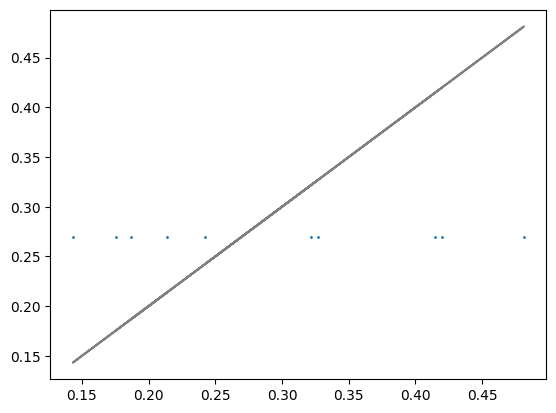

In [57]:

graph = build_graph(halo_pos[:10], k, use_pbc=True, use_edges=True)
omega_m_pred = gnn.apply(params, graph)
print(omega_m_pred.shape)

plt.scatter(omega_m[:10], omega_m_pred[:,0], s=1)
plt.plot(omega_m[:10], omega_m[:10], color='gray')